In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from eden.util import configure_logging
import logging
configure_logging(logging.getLogger(),verbosity=1)

In [3]:
%%time
'''
FIRST WE TRAIN A GRAPHSAMPLER
'''
import sys
sys.path.append('..')
import os 
os.nice(20)
%matplotlib inline

import graphlearn.utils.draw as myutils
import graphlearn.graphlearn as gl
from eden.converter.graph.gspan import gspan_to_eden
import itertools

# setting things up...
training_graphs = gspan_to_eden( 'bursi.pos.gspan' )
training_size=200
training_graphs = itertools.islice(training_graphs,training_size)
sampler=gl.GraphLearnSampler()#radius_list=[1,2],thickness_list=[1,2])

#fitting sampler
sampler.fit(training_graphs,n_jobs=-1, min_cip_count=3, min_interface_count=3)
sampler.save('tmp/sampler_200.ge')

#loading sampler
sampler.load('tmp/sampler_200.ge')


CPU times: user 21.1 s, sys: 1.46 s, total: 22.6 s
Wall time: 30.9 s


In [4]:
'''
ok,lets set all the options just to make sure we didnt miss any
'''
sampler.same_radius = False
sampler.similarity = -1
sampler.sampling_interval = 9999
sampler.n_steps = 100
sampler.n_jobs = 1
sampler.same_core_size = False
sampler.accept_annealing_factor = 1
sampler.accept_static_penalty = 1
sampler.select_cip_max_tries = 100
sampler.burnout = 0
sampler.batch_size = 1
sampler.probabilistic_core_choice = True
sampler.generatormode = False
sampler.keep_duplicates = True
sampler.lsgg.preprocessing(n_jobs=1,
                           same_radius=sampler.same_radius,
                           same_core_size=sampler.same_core_size,
                           probabilistic_core_choice=sampler.probabilistic_core_choice)

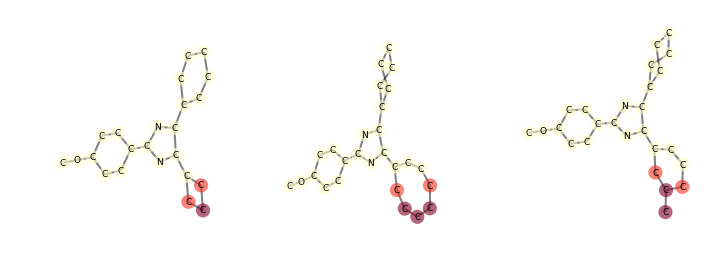

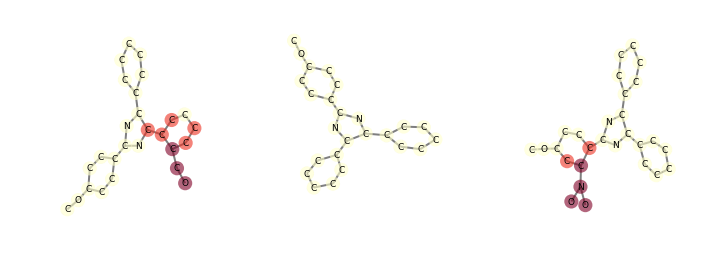

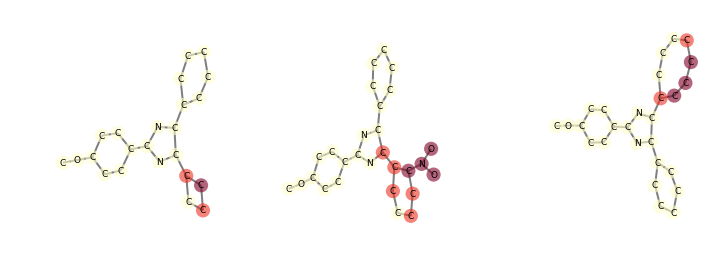

8


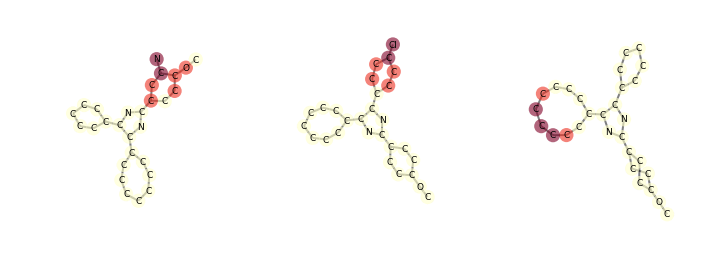

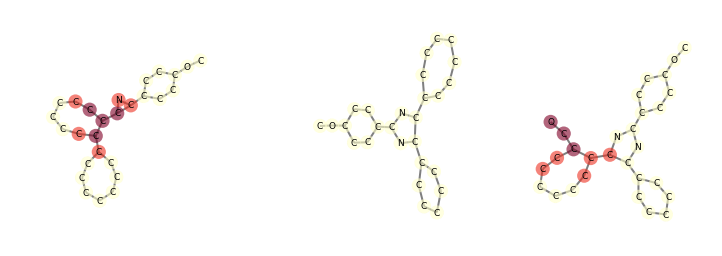

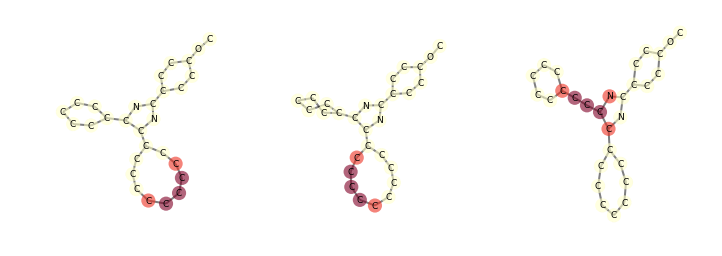

7


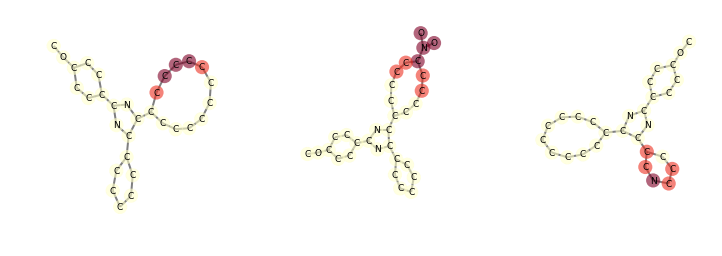

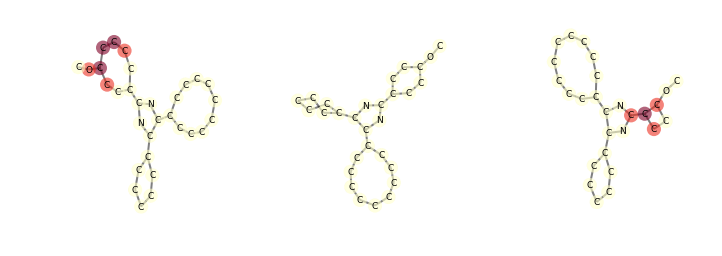

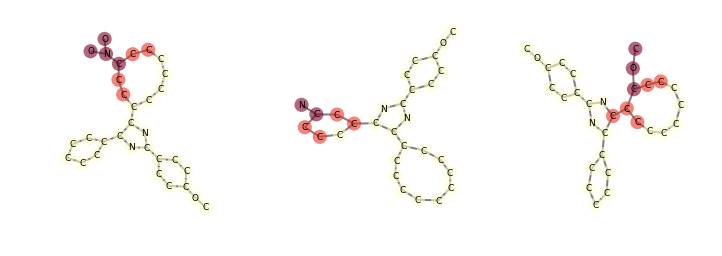

6


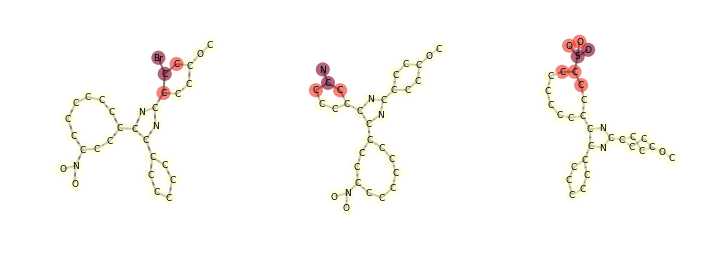

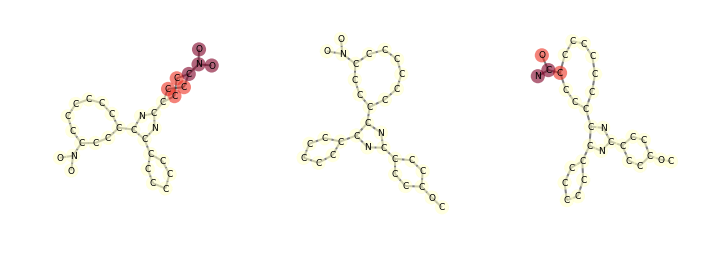

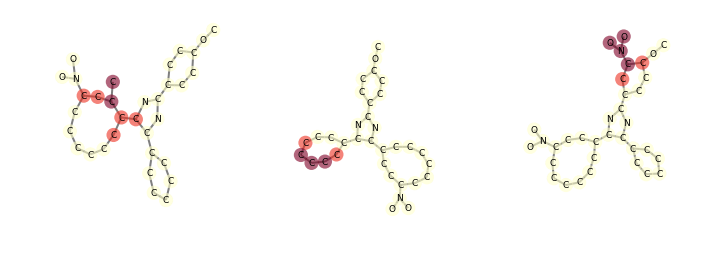

KeyboardInterrupt: 

In [5]:
'''
easy mode
'''
from graphlearn import graphtools
import networkx as nx


def get_new_graphs(gr):
    res=[]
    graphtools.graph_clean(gr)
    for i in range(8):
        gr2=nx.Graph(gr)
        cip = sampler.select_original_cip(gr2)
        newcip = sampler._select_cips(cip).next()
        newgr=graphtools.core_substitution(gr2, cip.graph, newcip.graph)
        res.append(newgr)
    return res


from graphlearn.utils.draw import draw_graph_set_graphlearn
gr = gspan_to_eden( 'bursi.pos.gspan' )
CURRENT = gr.next()
CURRENT = sampler.vectorizer._edge_to_vertex_transform(CURRENT)

while True:
    # generate 8 graphs
    g=get_new_graphs(CURRENT)
    
    # put old ine in middle
    graphtools.graph_clean(CURRENT)
    g=g[:4]+[CURRENT]+g[4:]
    
    # draw them 
    draw_graph_set_graphlearn(g,n_graphs_per_line=3, node_size=200)
    
    #pick one
    x=raw_input()
    CURRENT=g[int(x)]

/Users/costa/anaconda/lib/python2.7/site-packages/matplotlib/text.py:52: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if rotation in ('horizontal', None):
/Users/costa/anaconda/lib/python2.7/site-packages/matplotlib/text.py:54: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif rotation == 'vertical':


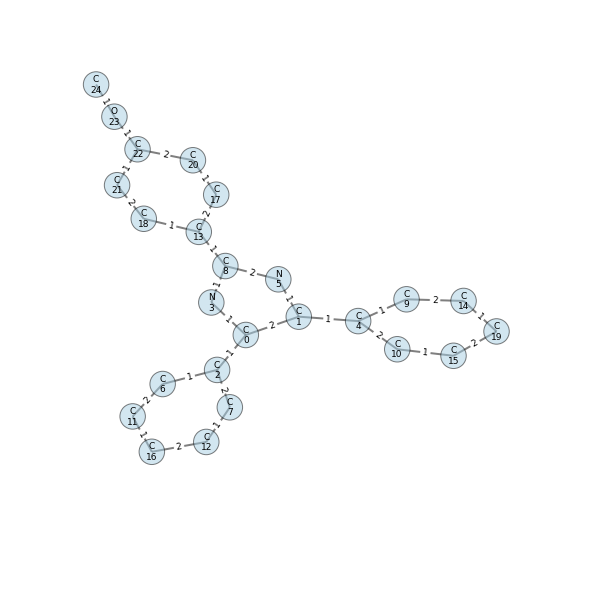

4


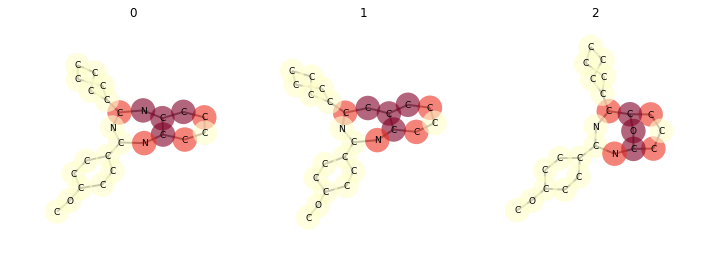

2


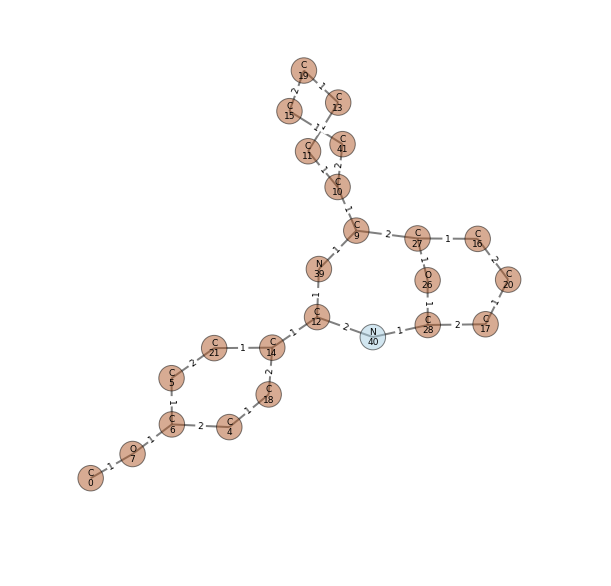

In [ ]:
%%time
'''
maximum control mode
'''
from graphlearn import graphtools
import networkx as nx
from eden.util import display
from eden.modifier.graph.vertex_attributes import colorize 

def extract(x,graph):
    return graphtools.extract_core_and_interface(x, graph, [2], [2], 
            vectorizer=sampler.vectorizer,
            hash_bitmask=sampler.hash_bitmask, filter=sampler.node_entity_check)

def getids(graph):
    res=[]
    for n in graph.nodes():
        if 'edge' in graph.node[n]:
            continue
        cip=extract(n,graph)
        if not cip:
            continue
        if cip[0].interface_hash in sampler.lsgg.grammar:
            res.append(n)
    return res
            
    
def get_new_graphs(gr,cores,oldcip):
    res=[]
    graphtools.graph_clean(gr)
    news= [ cip.graph for cip in cores.itervalues() ]
    for i,core in enumerate(news):
        newgr=graphtools.core_substitution(gr,oldcip.graph,core)
        newgr.graph['info2']=str(i)
        res.append(newgr)
    return res

def set_id_label(graph):
    # not sure if this should be fixed in eden..
    # i suspect that eden sets an ID and then assumes that nobody will ever mess with it..
    # surely, nobody has the intent of replacing parts of the graph... or building a wall for that matter.. 
    for n,d in graph.nodes(data=True):
        d['ID']=str(n)
    

from graphlearn.utils.draw import draw_graph_set_graphlearn
gr = gspan_to_eden( 'bursi.pos.gspan' )
CURRENT = gr.next()
CURRENT = sampler.vectorizer._edge_to_vertex_transform(CURRENT)

    
while True:
    
    # draw graph and tell user which cores are ok to pick: 
    ids = getids(CURRENT)
    set_id_label(CURRENT)
    C=nx.Graph(CURRENT)
    C=sampler.vectorizer._revert_edge_to_vertex_transform(CURRENT)
    
    for n in ids:
        C.node[n]['color_level']=.5
    
    display.draw_graph(C, size=10, secondary_vertex_label='ID',
                   colormap='Paired', invert_colormap=False,node_border=0.5, vertex_color='color_level',
                   vertex_alpha=0.5, node_size=650)
    x=raw_input()
    x=int(x)
    
    

    
    #ok we have a node, lets get a cip
    cip =extract(x, CURRENT)
    cip=cip[0]
    
    # lets get all the hits in the grammar
    corez=sampler.lsgg.grammar[cip.interface_hash]
    
    # let the user choose from some options we get from get_new_graphs:
    g=get_new_graphs(CURRENT,corez,cip)
    draw_graph_set_graphlearn(g,n_graphs_per_line = 5,title_key='info2')
    x=raw_input()
    
    CURRENT=g[int(x)]
    #CURRENT=graphtools.core_substitution(CURRENT, cip.graph, g[int(x)])
    
    
    


In [ ]:
'''
easy mode, WIDGET VERSION
'''
from graphlearn import graphtools
import networkx as nx


from graphlearn.utils.draw import draw_graph_set_graphlearn
gr = gspan_to_eden( 'bursi.pos.gspan' )
CURRENT = gr.next()
gr = sampler.vectorizer._edge_to_vertex_transform(CURRENT)

res=[gr for i in range(9)]

def get_new_graphs(choice,res):
    gr=res[choice]
    res=[]
    graphtools.graph_clean(gr)
    for i in range(8):
        gr2=nx.Graph(gr)
        cip = sampler.select_original_cip(gr2)
        newcip = sampler._select_cips(cip).next()
        newgr=graphtools.core_substitution(gr2, cip.graph, newcip.graph)
        res.append(newgr)

    graphtools.graph_clean(CURRENT)
    res=res[:4]+[gr]+res[4:]       
    draw_graph_set_graphlearn(res,n_graphs_per_line = 3)    
    


from IPython.html.widgets import interact
interact(get_new_graphs, 
               choice=(0,9),res=res)


    


In [11]:
'''
we failed miserably.. lets try something else
'''
from graphlearn import graphtools
import networkx as nx

import random
from graphlearn.utils.draw import draw_graph_set_graphlearn
gr = gspan_to_eden( 'bursi.pos.gspan' )
CURRENT = gr.next()
gr = sampler.vectorizer._edge_to_vertex_transform(CURRENT)

res=[gr for i in range(9)]

def get_new_graphs(a):
    choice= random.randint(0,9)
    gr=res[choice]
    res=[]
    graphtools.graph_clean(gr)
    for i in range(8):
        gr2=nx.Graph(gr)
        cip = sampler.select_original_cip(gr2)
        newcip = sampler._select_cips(cip).next()
        newgr=graphtools.core_substitution(gr2, cip.graph, newcip.graph)
        res.append(newgr)

    graphtools.graph_clean(CURRENT)
    res=res[:4]+[gr]+res[4:]       
    draw_graph_set_graphlearn(res,n_graphs_per_line = 3)    
    


from IPython.html.widgets import interact
from IPython.html import widgets
from IPython.display import display
button = widgets.ButtonWidget(description="Click Me!")
display(button)



button.on_click(get_new_graphs)
    

UnboundLocalError: local variable 'res' referenced before assignment